# Notebook 1: Introduction to LangGraph & Basic Graphs

## Learning Objectives
- Understand what LangGraph is and when to use it
- Learn the core concepts: State, Nodes, Edges
- Build your first LangGraph application

## What is LangGraph?

LangGraph is a library for building **stateful, multi-actor applications** with LLMs. It extends LangChain with:

- **Cycles**: Unlike simple chains, graphs can loop back
- **State Management**: Persistent state across nodes
- **Controllability**: Fine-grained control over flow

### When to use LangGraph vs LangChain?

| Use Case | LangChain | LangGraph |
|----------|-----------|------------|
| Simple prompt → response | ✅ | ❌ |
| Linear chains | ✅ | ❌ |
| Agents with tool loops | ⚠️ | ✅ |
| Multi-agent systems | ❌ | ✅ |
| Complex branching logic | ❌ | ✅ |
| Human-in-the-loop | ❌ | ✅ |

## Setup

First, let's load our environment variables and import the necessary libraries.

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

# Verify API key is loaded
assert os.getenv("OPENAI_API_KEY"), "Please set OPENAI_API_KEY in your .env file"

## Core Concepts

LangGraph has three fundamental building blocks:

### 1. State
A TypedDict that defines what data flows through your graph. Every node reads from and writes to this state.

### 2. Nodes
Functions that take the current state and return updates to it. Nodes do the actual work (calling LLMs, processing data, etc.).

### 3. Edges
Connections between nodes that define the flow. Can be:
- **Normal edges**: Always go from A → B
- **Conditional edges**: Choose next node based on state

## Example 1: A Simple Graph (No LLM)

Let's start with a simple graph that doesn't use an LLM to understand the mechanics.

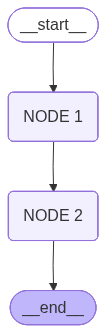

In [4]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

# Step 1: Define the State
class SimpleState(TypedDict):
    message: str
    count: int

# Step 2: Define Node functions
def add_greeting(state: SimpleState) -> dict:
    """Add a greeting to the message"""
    return {"message": f"Hello! {state['message']}"}

def increment_count(state: SimpleState) -> dict:
    """Increment the counter"""
    return {"count": state["count"] + 1}

def finalize(state: SimpleState) -> dict:
    """Add a farewell to the message"""
    return {"message": f"{state['message']} Goodbye!"}

# Step 3: Build the Graph
builder = StateGraph(SimpleState)

# Add nodes
builder.add_node("greet", add_greeting)
builder.add_node("count", increment_count)
builder.add_node("finalize", finalize)

# Add edges
builder.add_edge(START, "greet")
builder.add_edge("greet", "count")
builder.add_edge("count", "finalize")
builder.add_edge("finalize", END)

# Step 4: Compile the graph
graph = builder.compile()

# Visualize the graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Run the graph
initial_state = {"message": "Welcome to LangGraph.", "count": 0}
result = graph.invoke(initial_state)

print(f"Final message: {result['message']}")
print(f"Final count: {result['count']}")

## Example 2: A Simple Chatbot with LLM

Now let's build a simple chatbot using LangGraph with an actual LLM.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

# Define state with message history
# The `add_messages` annotation tells LangGraph to append messages rather than replace
class ChatState(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize the LLM
llm = ChatOpenAI(model="gpt-5-mini", temperature=0.7)

# Define the chatbot node
def chatbot(state: ChatState) -> dict:
    """Process messages and generate a response"""
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

# Build the graph
builder = StateGraph(ChatState)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

chat_graph = builder.compile()

# Visualize
display(Image(chat_graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

# Test the chatbot
response = chat_graph.invoke({
    "messages": [HumanMessage(content="What is LangGraph in one sentence?")]
})

print(response["messages"][-1].content)

## Understanding `add_messages`

The `add_messages` reducer is crucial for chat applications. It:
- **Appends** new messages to the list (instead of replacing)
- **Handles deduplication** by message ID
- **Supports updates** to existing messages

This is what makes conversation history work!

In [ ]:
# Demonstrate message accumulation
from langchain_core.messages import HumanMessage, AIMessage

# Simulate a multi-turn conversation
conversation = [
    HumanMessage(content="Hi, my name is Alice."),
    AIMessage(content="Hello Alice! Nice to meet you. How can I help you today?"),
    HumanMessage(content="What's my name?")
]

response = chat_graph.invoke({"messages": conversation})
print(response["messages"][-1].content)

---

## Exercise 1: Build Your Own Graph

Create a graph that:
1. Takes a topic as input
2. Uses an LLM to generate a joke about that topic
3. Uses another LLM call to rate the joke (1-10)
4. Returns both the joke and the rating

**Hints:**
- Define a state with `topic`, `joke`, and `rating` fields
- Create two nodes: `generate_joke` and `rate_joke`
- Connect them: START → generate_joke → rate_joke → END

In [ ]:
# YOUR CODE HERE

# Step 1: Define the State
class JokeState(TypedDict):
    topic: str
    joke: str
    rating: int

# Step 2: Define the nodes
def generate_joke(state: JokeState) -> dict:
    # TODO: Use the LLM to generate a joke about state["topic"]
    pass

def rate_joke(state: JokeState) -> dict:
    # TODO: Use the LLM to rate the joke from 1-10
    pass

# Step 3: Build and compile the graph
# TODO: Create the graph

# Step 4: Test it
# result = joke_graph.invoke({"topic": "programming", "joke": "", "rating": 0})
# print(f"Joke: {result['joke']}")
# print(f"Rating: {result['rating']}/10")

### Exercise 1: Solution (hidden)

<details>
<summary>Click to reveal solution</summary>

```python
class JokeState(TypedDict):
    topic: str
    joke: str
    rating: int

def generate_joke(state: JokeState) -> dict:
    response = llm.invoke(f"Tell me a short, funny joke about {state['topic']}")
    return {"joke": response.content}

def rate_joke(state: JokeState) -> dict:
    response = llm.invoke(
        f"Rate this joke from 1-10 (just respond with the number): {state['joke']}"
    )
    try:
        rating = int(response.content.strip())
    except:
        rating = 5
    return {"rating": rating}

builder = StateGraph(JokeState)
builder.add_node("generate_joke", generate_joke)
builder.add_node("rate_joke", rate_joke)
builder.add_edge(START, "generate_joke")
builder.add_edge("generate_joke", "rate_joke")
builder.add_edge("rate_joke", END)

joke_graph = builder.compile()

result = joke_graph.invoke({"topic": "programming", "joke": "", "rating": 0})
print(f"Joke: {result['joke']}")
print(f"Rating: {result['rating']}/10")
```
</details>

## Key Takeaways

1. **State** is the backbone - it flows through every node
2. **Nodes** are functions that read state and return updates
3. **Edges** define the execution flow
4. Use **add_messages** for conversation history
5. Always **compile** your graph before running it

## Next: Conditional Routing

In the next notebook, we'll learn how to add branching logic to our graphs!